# Notebook to extract spectral indices and LST from Landsat 8 satellite through Python API from Google Earth Engine

**Notebook requirements**

In [122]:
# importing libraries
import ee
import geemap
import geopandas as gpd
import pathlib
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from IPython.display import IFrame # variable for visualization

# python script for heatwave detection
from heatwave_detection import get_heatwave

In [2]:
# establishing relative paths to directories
NOTEBOOK_DIRECTORY = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_DIRECTORY / "data"
OUTPUT_DIRECTORY = NOTEBOOK_DIRECTORY / "output" / "climate_data"

In [3]:
# initializing Google Earth Engine
try: 
    ee.Initialize()
except Exception as e:

    ee.Authenticate()
    ee.Initialize()

Enter verification code:  4/1AUJR-x6F_S0uekC2_tbC7zWq4TPkVVAEmTFrcn2PBAqn3_EQkpNZisfEB0U



Successfully saved authorization token.


## Data Import

**Txt and Vector**

In [79]:
# importing heatwave data
air_temp_13_24 = pd.read_csv(
    # defining filepath
    DATA_DIRECTORY / "air_temp" / "air_temp_2024.txt",
    # parsing datetime objects
    parse_dates=["Date"],
).set_index("Date") # setting DataFrame index on parsed datetime column

In [5]:
tallinn = gpd.read_file(DATA_DIRECTORY / "tallinn_outline" / "tallinn_dissolved.gpkg", layer=1)
tallinn = geemap.gdf_to_ee(tallinn)

In [6]:
# export extent to keep the export as small as possible but cover the LCZ map
extent = gpd.read_file(DATA_DIRECTORY / "si_extent_2014.gpkg")
extent = geemap.gdf_to_ee(extent)

**Satellite Images**

In [4]:
# Location of Tallinn
tallinn_center = ee.Geometry.Point(24.751965, 59.430752)

In [5]:
# Loading and filtering Landsat 8 (surface reflection) collection
landsatCollection_SR = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                     # Satellite program: Landsat 
                     # LC08: 8th version
                     # CO2: Collection 2
                     # T1: Tier 1, the highest-quality data suitable for time-series analysis
                     # L2: Level-2 Science Products, includes atmospherically corrected surface reflectance
                       .filterBounds(tallinn_center) # spatial filter
                    )

## Helper Functions

In [9]:
# Landsat 8 Level 2 (L2) images are classified as Analysis Ready Data (Atmospheric Correction: Converts Top-of-Atmosphere (TOA) reflectance to Surface Reflectance (SR),
# Cloud Masking and Geometric Correction: Ensures accurate geographic alignment)
# Nevertheless it provides data in Digital Numbers (DN). These DN values must be converted to physical reflectance or temperature units using scaling factors.

# raster rescaling
def apply_scale_factors(raster_image):
    # Bands affected: all optical bands 'SR-B1' - 'SR-B7'
    # Formula: Surface Reflectance[ranging from 0 to 1] = (DN * 0.0000275[=gain]) - 0.2[=additive correction]
    optical_bands = raster_image.select('SR_B.').multiply(0.0000275).add(-0.2)
    # Bands affected: 'ST_B10', 'ST_B11', Formula: Temperature (Celsius) = (DN * 0.00341802) + 149.0
    thermal_bands = raster_image.select('ST_B.*').multiply(0.00341802).add(-124.15)
    # adds the corrected value back to the image 
    return raster_image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

In [10]:
def create_maps_from_collections(collections_by_year, vis_params, boundary):
    maps = {}

    for year, collection_list in collections_by_year.items():
        # Create a new interactive map
        map_selection = geemap.Map(center=[59.430752, 24.751965], zoom=11)

        # Iterate over image list and add to map
        for i in range(collection_list.size().getInfo()):
            image = ee.Image(collection_list.get(i))
            label = f"{image.get('DATE_ACQUIRED').getInfo()} / list position: {i}"
            map_selection.add_layer(image, vis_params, label)

        # Add boundary overlay
        map_selection.add_layer(boundary, {}, "Boundary")

        # Store map
        maps[year] = map_selection

    return maps

In [11]:
# raster reprojecting
def raster_reproject(raster_image):
    
    raster_reprojected = raster_image.reproject(
        crs="EPSG:3301",
        scale=30 # resolution of Landsat 8 = 30 m
    )
    return raster_reprojected

In [12]:
# NDVI calculation (because of band-selection only working for Landsat 8)
def calculate_NDVI(raster_image):
    # building the normalized difference form NIR and RED band
    ndvi = raster_image.normalizedDifference(['SR_B5', 'SR_B4']).rename("NDVI")
    return ndvi

In [13]:
# NDWI calculation (because of band-selection only working for Landsat 8)
def calculate_NDWI(raster_image):
    # building the normalized difference form NIR and GREEN band
    ndwi = raster_image.normalizedDifference(['SR_B3', 'SR_B5']).rename("NDWI")
    return ndwi

In [14]:
# NDBI calculation (because of band-selection only working for Landsat 8)
def calculate_NDBI(raster_image):
    # building the normalized difference form SWIR1 and NIR band
    ndbi = raster_image.normalizedDifference(['SR_B6', 'SR_B5']).rename("NDBI")
    return ndbi

In [53]:
def conduct_processing(image):
    
    # applying re-scale function
    image = apply_scale_factors(image)
    print('Image rescaled')
    # applying reproject function
    image = raster_reproject(image)   
    print(f"Image reprojected: {image.projection().getInfo()}")

    # applying NDVI calculation function
    NDVI = calculate_NDVI(image)
    print('NDVI calculated')
    # applying NDWI calculation function
    NDWI = calculate_NDWI(image)
    print('NDWI calculated')
    # applying NDBI calculation function
    NDBI = calculate_NDBI(image)
    print('NDBI calculated')

    # extracting land surface temperature
    LST = image.select(['ST_B10']).rename(['LST'])
    print('Land surface temperature extracted')
    # extracting min, max and mean
    max_dict = geemap.image_max_value(LST).getInfo()
    min_dict = geemap.image_min_value(LST).getInfo()
    mean_dict = geemap.image_mean_value(LST).getInfo()
    print(f"On the {image.get('DATE_ACQUIRED').getInfo()} the minimum land surface temperature was {round(min_dict['LST'],2)}, the maximum was {round(max_dict['LST'],2)} and the mean was {round(mean_dict['LST'],2)} °C")

    true_color = image.select(['SR_B4', 'SR_B3', 'SR_B2']).toFloat()
    print('True color composite prepared')
    
    return true_color, NDVI, NDWI, NDBI, LST

In [54]:
def extract_LST(image):
    
    # applying re-scale function
    image = apply_scale_factors(image)
    print('Image rescaled')
    # applying reproject function
    image = raster_reproject(image)   
    print(f"Image reprojected: {image.projection().getInfo()}")

    # extracting land surface temperature
    LST = image.select(['ST_B10']).rename(['LST'])
    print('Land surface temperature extracted')
    # extracting min, max and mean
    max_dict = geemap.image_max_value(LST).getInfo()
    min_dict = geemap.image_min_value(LST).getInfo()
    mean_dict = geemap.image_mean_value(LST).getInfo()
    print(f"On the {image.get('DATE_ACQUIRED').getInfo()} the minimum land surface temperature was {round(min_dict['LST'],2)}, the maximum was {round(max_dict['LST'],2)} and the mean was {round(mean_dict['LST'],2)} °C")

    true_color = image.select(['SR_B4', 'SR_B3', 'SR_B2']).toFloat()
    print('True color composite prepared')
    
    return true_color, LST

In [17]:
# Function to automate export
def export_images_to_drive(image_list, description_list, folder, scale, region_geometry):
    for image, description in zip(image_list, description_list):
        task = ee.batch.Export.image.toDrive(**{
            'image': image,
            'description': description,
            'folder': folder,
            'scale': scale,
            'region': region_geometry
        })
        task.start()
        print(f"Export started for {description}")

## Heatwave detection

In [15]:
# calling 
heatwave_periods = get_heatwave(air_temp_13_24)

In [80]:
air_temp_13_24

,air_temp
Date,
2013-01-01,3.8
2013-01-02,2.8
2013-01-03,1.5
2013-01-04,1.7
2013-01-05,1.5
...,...
2024-12-27,6.1
2024-12-28,4.4
2024-12-29,5.4


In [89]:
summer_14 = air_temp_13_24.loc['2014-05-01':'2014-09-30']
summer_22 = air_temp_13_24.loc['2022-05-01':'2022-09-30']

/var/folders/2s/0nsm0xkj0pdcsd9gc7jk66q00000gn/T/ipykernel_35336/3500591903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_14['month_day'] = pd.to_datetime('2000-' + summer_14.index.strftime('%m-%d'))
/var/folders/2s/0nsm0xkj0pdcsd9gc7jk66q00000gn/T/ipykernel_35336/3500591903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_22['month_day'] = pd.to_datetime('2000-' + summer_22.index.strftime('%m-%d'))


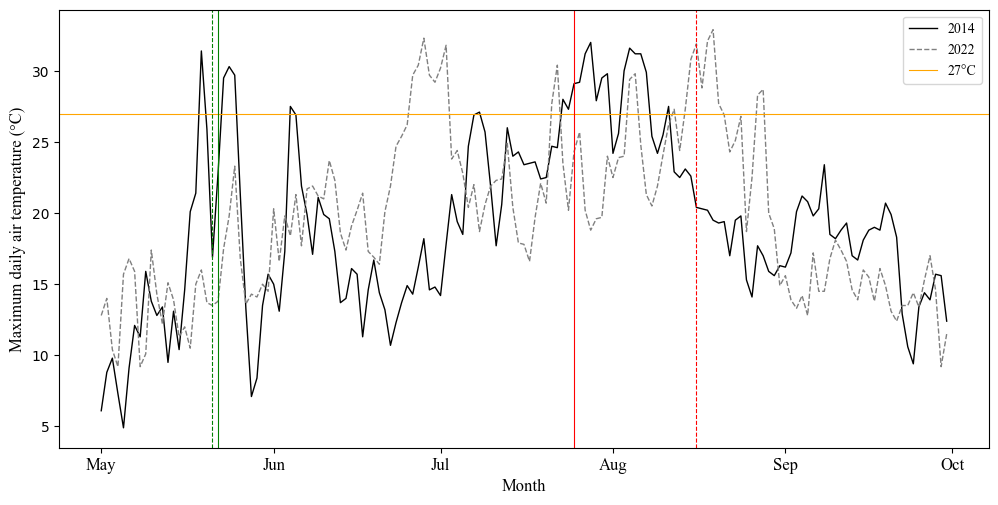

In [127]:
# dummy year datetime for x-axis
summer_14['month_day'] = pd.to_datetime('2000-' + summer_14.index.strftime('%m-%d'))
summer_22['month_day'] = pd.to_datetime('2000-' + summer_22.index.strftime('%m-%d'))

# Start plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot temperature lines
ax.plot(summer_14['month_day'], summer_14['air_temp'], color='black', label='2014', linewidth=1)
ax.plot(summer_22['month_day'], summer_22['air_temp'], color='gray', linestyle='--', label='2022', linewidth=1)

# Add horizontal heatwave threshold line
ax.axhline(y=27, color='orange', linestyle='-', linewidth=0.8, label='27°C')

# Satellite selection markers
satellite_days = [
    {'date': '05-22', 'year': 2014, 'color': 'green', 'linestyle': '-'},  # non-heatwave
    {'date': '07-25', 'year': 2014, 'color': 'red',   'linestyle': '-'},  # heatwave
    {'date': '05-21', 'year': 2022, 'color': 'green', 'linestyle': '--'}, # non-heatwave
    {'date': '08-16', 'year': 2022, 'color': 'red',   'linestyle': '--'}  # heatwave
]

# Add vertical markers
for entry in satellite_days:
    dt = pd.to_datetime(f"2000-{entry['date']}")
    ax.axvline(x=dt, color=entry['color'], linestyle=entry['linestyle'], linewidth=0.8)

# Format x-axis
xticks = pd.date_range("2000-05-01", "2000-10-01", freq="MS")
ax.set_xticks(xticks)
ax.set_xticklabels([d.strftime('%b') for d in xticks], fontname='Times New Roman', fontsize=12)
ax.set_xlabel('Month', fontname='Times New Roman', fontsize=12)
ax.set_ylabel('Maximum daily air temperature (°C)', fontname='Times New Roman', fontsize=12)

# Create font properties
times_new_roman = FontProperties(family='Times New Roman')

# Apply it to the legend
ax.legend(prop=times_new_roman, fontsize=12)

# Add spacing to bottom in case you want text annotations later
plt.subplots_adjust(bottom=0.15)

plt.savefig('/Users/moritzmuhlbauer/Master Thesis/output/plots/air_temp_selection_plot.jpg', dpi=600)

plt.show()

## Image Selection

### Collections by year

In [6]:
# Define temporal filters
# filter satellite images with index acess from heatwave DataFrame
# already pre filter on month with heatwave period
collection_2014 = landsatCollection_SR.filterDate('2014-05-01', '2014-08-31')
collection_2018 = landsatCollection_SR.filterDate('2018-07-15', '2018-08-03')
collection_2019 = landsatCollection_SR.filterDate('2019-06-04', '2019-06-08')
collection_2020 = landsatCollection_SR.filterDate('2020-06-26', '2020-06-28')
collection_2021 = landsatCollection_SR.filterDate('2021-06-18', '2021-07-16')
collection_2022 = landsatCollection_SR.filterDate('2022-05-01', '2022-08-31')
collection_2024 = landsatCollection_SR.filterDate('2024-05-27', '2024-05-29')

In [19]:
# checking quantity of the pictures
print(f"2014 has {collection_2014.size().getInfo()} pictures")
print(f"2018 has {collection_2018.size().getInfo()} pictures")
print(f"2019 has {collection_2019.size().getInfo()} pictures")
print(f"2020 has {collection_2020.size().getInfo()} pictures")
print(f"2021 has {collection_2021.size().getInfo()} pictures")
print(f"2022 has {collection_2022.size().getInfo()} pictures")
print(f"2024 has {collection_2024.size().getInfo()} pictures")

2014 has 25 pictures
2018 has 4 pictures
2019 has 2 pictures
2020 has 0 pictures
2021 has 7 pictures
2022 has 26 pictures
2024 has 0 pictures


In [20]:
# checking available days per month
print(f"Available dates 2014: {geemap.image_dates(collection_2014).getInfo()}\n")
print(f"Available dates 2022: {geemap.image_dates(collection_2022).getInfo()}")

Available dates 2014: ['2014-05-15', '2014-05-31', '2014-06-16', '2014-07-02', '2014-07-18', '2014-08-03', '2014-08-19', '2014-05-06', '2014-05-22', '2014-06-07', '2014-06-23', '2014-07-09', '2014-07-25', '2014-08-10', '2014-08-26', '2014-05-06', '2014-05-22', '2014-06-07', '2014-06-23', '2014-07-09', '2014-07-25', '2014-08-10', '2014-05-13', '2014-08-01', '2014-08-17']

Available dates 2022: ['2022-05-05', '2022-05-21', '2022-06-06', '2022-06-22', '2022-07-08', '2022-08-09', '2022-08-25', '2022-05-28', '2022-06-13', '2022-06-29', '2022-07-15', '2022-07-31', '2022-08-16', '2022-05-28', '2022-06-13', '2022-06-29', '2022-07-15', '2022-07-31', '2022-08-16', '2022-05-03', '2022-05-19', '2022-06-04', '2022-07-06', '2022-07-22', '2022-08-07', '2022-08-23']


In [21]:
#print(f"Available bands: {ee.Image(collection_20.first()).bandNames().getInfo()}")

In [22]:
# visualization parameters for a true color composite of Landast 8 images before re-scaling
vis_params_tc = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # True Color (Red-Green-Blue)
    'min': 7000,
    'max': 15000
}

In [7]:
# converting image collection to list
collection_2014_list = collection_2014.toList(collection_2014.size())
collection_2018_list = collection_2018.toList(collection_2018.size())
collection_2019_list = collection_2019.toList(collection_2019.size())
collection_2021_list = collection_2021.toList(collection_2021.size())
collection_2022_list = collection_2022.toList(collection_2022.size())

### Visual screening on interactive map extent

In [24]:
# now all available pictures can be selected based on cloud cover and coverage and the best fitting can be selected for further processing
# because of the heatwave comparison, exact days must be selected. This is one way to identify and use single images and extract them out of feature collection. For cloud-cover free scenes,
# median composites of multiple pictures safed in one image collection could be used. Like this, a precise determination of heatdays and non-heatdays will not be possible when analyising thermal bands

# loading all images of the image collection onto one map extent and selecting the best fit regarding coverage and clouds 
# initializing a interactive map extent
collections_by_year = {
    2014: collection_2014_list,
    2018: collection_2018_list,
    2019: collection_2019_list,
    2021: collection_2021_list,
    2022: collection_2022_list
}

maps = create_maps_from_collections(collections_by_year, vis_params_tc, tallinn)

# Display the maps:
#maps[2014]
#maps[2018]
#maps[2019]
#maps[2021]
#maps[2022]

In [26]:
maps[2022]

Map(center=[59.430752, 24.751965], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

### Image selection from collection list

#### 2014

**Heatwave**

In [8]:
image_2014_07_25_1 = ee.Image(collection_2014_list.get(12)) # for mosaic creation
image_2014_07_25_2 = ee.Image(collection_2014_list.get(20)) # for mosaic creation

image_2014_08_03 = ee.Image(collection_2014_list.get(5)) # single image covering tallinn for comparison

**No Heatwave**

In [10]:
image_2014_05_22_1 = ee.Image(collection_2014_list.get(8)) # for mosaic creation
image_2014_05_22_2 = ee.Image(collection_2014_list.get(16)) # for mosaic creation

#### 2022

**Heatwave**

In [11]:
image_2022_08_16_1 = ee.Image(collection_2022_list.get(12)) # for mosaic creation
image_2022_08_16_2 = ee.Image(collection_2022_list.get(18)) # for mosaic creation

**No Heatwave**

In [12]:
image_2022_05_21 = ee.Image(collection_2022_list.get(1)) # single image covering tallinn for comparison

image_2022_06_06 = ee.Image(collection_2022_list.get(2)) # single image covering tallinn for comparison

---

In [13]:
# acquisition time (system:time_start is in milliseconds since epoch)
timestamp_ms_2014_08_03 = image_2014_08_03.get('system:time_start').getInfo()

timestamp_ms_2014_1 = image_2014_07_25_1.get('system:time_start').getInfo()
timestamp_ms_2014_2 = image_2014_07_25_2.get('system:time_start').getInfo()

timestamp_ms_2022_1 = image_2022_08_16_1.get('system:time_start').getInfo()
timestamp_ms_2022_2 = image_2022_08_16_2.get('system:time_start').getInfo()

# converting to human-readable datetime
acquisition_time_2014_08_03 = datetime.utcfromtimestamp(timestamp_ms_2014_08_03 / 1000)

acquisition_time_2014_1 = datetime.utcfromtimestamp(timestamp_ms_2014_1 / 1000)
acquisition_time_2014_2 = datetime.utcfromtimestamp(timestamp_ms_2014_2 / 1000)

acquisition_time_2022_1 = datetime.utcfromtimestamp(timestamp_ms_2022_1 / 1000)
acquisition_time_2022_2 = datetime.utcfromtimestamp(timestamp_ms_2022_2 / 1000)

print(f"Acquisition time of heatwave mosaic in 2014: {acquisition_time_2014_1} and {acquisition_time_2014_2}\nAcquisition time heatwave mosaic in 2022: {acquisition_time_2022_1} and {acquisition_time_2022_2}\n")
print(f"Acquistion time of single heatwave image in 2014: {acquisition_time_2014_08_03}")

Acquisition time of heatwave mosaic in 2014: 2014-07-25 09:29:32.689000 and 2014-07-25 09:29:56.580000
Acquisition time heatwave mosaic in 2022: 2022-08-16 09:30:11.455000 and 2022-08-16 09:30:35.337000

Acquistion time of single heatwave image in 2014: 2014-08-03 09:23:52.442000


In [32]:
# Get the acquisition time (system:time_start is in milliseconds since epoch)

timestamp_ms_2014_05_22_1 = image_2014_05_22_1.get('system:time_start').getInfo()
timestamp_ms_2014_05_22_2 = image_2014_05_22_2.get('system:time_start').getInfo()

timestamp_ms_2022_05_21 = image_2022_05_21.get('system:time_start').getInfo()

timestamp_ms_2022_06_06 = image_2022_06_06.get('system:time_start').getInfo()

# Convert to human-readable datetime
acquisition_time_2014_05_22_1 = datetime.utcfromtimestamp(timestamp_ms_2014_05_22_1 / 1000)
acquisition_time_2014_05_22_2 = datetime.utcfromtimestamp(timestamp_ms_2014_05_22_2 / 1000)

acquisition_time_2022_05_21 = datetime.utcfromtimestamp(timestamp_ms_2022_05_21 / 1000)

acquisition_time_2022_06_06 = datetime.utcfromtimestamp(timestamp_ms_2022_06_06 / 1000)

print(f"Acquisition time of non heatwave mosaic in 2014: {acquisition_time_2014_05_22_1} and {acquisition_time_2014_05_22_2}\n")
print(f"Acquisition time of first non heatwave single image in 2022: {acquisition_time_2022_05_21}\n")
print(f"Acquisition time of second non heatwave single image in 2022: {acquisition_time_2022_06_06}\n")

Acquisition time of non heatwave mosaic in 2014: 2014-05-22 09:29:09.661000 and 2014-05-22 09:29:33.548000

Acquisition time of first non heatwave single image in 2022: 2022-05-21 09:23:49.542000

Acquisition time of second non heatwave single image in 2022: 2022-06-06 09:23:57.122000



Concluding, all the images (either heatwave or no heatwave/mosaic or single image) are acquired at almost the same time which is great for comparative analysis.

---

In [33]:
# creating mean collection composites per year #

# heatwave mosaic 2014 
mosaic_2014_07_25 = ee.ImageCollection([image_2014_07_25_1, image_2014_07_25_2]).mean()
aoi_14 = image_2014_07_25_1.geometry().union(image_2014_07_25_2.geometry())
mosaic_2014_07_25 = mosaic_2014_07_25.clip(aoi_14)

# heatwave mosaic 2022 
mosaic_2022_08_16 = ee.ImageCollection([image_2022_08_16_1, image_2022_08_16_2]).mean()
aoi_22 = image_2022_08_16_1.geometry().union(image_2022_08_16_2.geometry())
mosaic_2022_08_16 = mosaic_2022_08_16.clip(aoi_22)

# non heatwave mosaic 2014
mosaic_2014_05_22 = ee.ImageCollection([image_2014_05_22_1, image_2014_05_22_2]).mean()
aoi_14_2 = image_2014_05_22_1.geometry().union(image_2014_05_22_2.geometry())
mosaic_2014_05_22 = mosaic_2014_05_22.clip(aoi_14_2)

In [44]:
# QUALITY CONTROL: inspect every selected image #

map_image_selected = geemap.Map(center = [59.430752, 24.751965], zoom =11)

# single heatwave image of 2014
map_image_selected.add_layer(image_2014_08_03, vis_params_tc, f"{image_2014_08_03.get('DATE_ACQUIRED').getInfo()}")

# single non heatwave images of 2022
map_image_selected.add_layer(image_2022_05_21, vis_params_tc, f"{image_2022_05_21.get('DATE_ACQUIRED').getInfo()}")
map_image_selected.add_layer(image_2022_06_06, vis_params_tc, f"{image_2022_06_06.get('DATE_ACQUIRED').getInfo()}")


# single images of 2014 heatwave mosaic
map_image_selected.add_layer(image_2014_07_25_1, vis_params_tc, f"{image_2014_07_25_1.get('DATE_ACQUIRED').getInfo()}_1")
map_image_selected.add_layer(image_2014_07_25_2, vis_params_tc, f"{image_2014_07_25_2.get('DATE_ACQUIRED').getInfo()}_2")

# single images of 2022 heatwave mosaic
map_image_selected.add_layer(image_2022_08_16_1, vis_params_tc, f"{image_2022_08_16_1.get('DATE_ACQUIRED').getInfo()}_1")
map_image_selected.add_layer(image_2022_08_16_2, vis_params_tc, f"{image_2022_08_16_2.get('DATE_ACQUIRED').getInfo()}_2")

# single images of 2014 non heatwave mosaic
map_image_selected.add_layer(image_2014_05_22_1, vis_params_tc, f"{image_2014_05_22_1.get('DATE_ACQUIRED').getInfo()}_1")
map_image_selected.add_layer(image_2014_05_22_2, vis_params_tc, f"{image_2014_05_22_2.get('DATE_ACQUIRED').getInfo()}_2")

# heatwave mosaic 2014
map_image_selected.add_layer(mosaic_2014_07_25, vis_params_tc, f"hw mosaic 2014")
# heatwave mosaic 2022
map_image_selected.add_layer(mosaic_2022_08_16, vis_params_tc, f"hw mosaic 2022")
# non heatwave mosaic 2014
map_image_selected.add_layer(mosaic_2014_05_22, vis_params_tc, f"non hw mosaic 2014")


map_image_selected.add_layer(tallinn, {}, "Tallinn boundary")
map_image_selected.add_layer(extent, {}, "Export extent")
map_image_selected.to_html(filename='map_image_selected.html',width="100%",height="1000px")

map_image_selected

Map(center=[59.430752, 24.751965], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [25]:
# get some metadata on the image selection
#print(f"Projection: {image_20_06_23.projection().getInfo()}")
#print(f"Properties: {l8_2013_07_15.propertyNames().getInfo()}")
#print(f"Band Names: {image_20_06_23.bandNames().getInfo()}")
#print(f"Processing level: {image_20_06_23.get('PROCESSING_LEVEL').getInfo()}")

### test

## Image Processing

Besides `LST`, the spectral indices `NDWI`, `NDVI` and `NDBI` must be extracted for 2014 and 2022 for LCZ classification support. 
Those indices are not needed for every picture processed since especially the single images are used to control and compare LST varations on different days.
Therefore, the two processing functions `conduct_processing` where the image gets rescaled, reprojected, the spectral indices calculated and LST extracted and `extract_LST` where the image gets rescaled, reprojected and the LST extracted without spectral indices being calculated was written.
This approach saves processing power and time.

### 2014

**Heatwave**

In [55]:
# for 2014 heatwave single image using extract_lst
print('Processing for 2014 heatwave single image started ...\n')
image_2014_08_03_rscld, LST_2014_08_03 = extract_LST(image_2014_08_03)
print('\nProcessing finished\n')

Processing for 2014 heatwave single image started ...

Image rescaled
Image reprojected: {'type': 'Projection', 'crs': 'EPSG:3301', 'transform': [30, 0, 0, 0, -30, 0]}
Land surface temperature extracted
On the 2014-08-03 the minimum land surface temperature was -9.25, the maximum was 51.53 and the mean was 27.53 °C
True color composite prepared

Processing finished



In [56]:
# for 2014 heatwave mosaic using conduct_processing
print('Processing for 2014 heatwave mosaic started ...\n')
mosaic_2014_07_25_rscld, NDVI_2014_07_25, NDWI_2014_07_25, NDBI_2014_07_25, LST_2014_07_25 = conduct_processing(mosaic_2014_07_25)
print('\nProcessing finished\n')

Processing for 2014 heatwave mosaic started ...

Image rescaled
Image reprojected: {'type': 'Projection', 'crs': 'EPSG:3301', 'transform': [30, 0, 0, 0, -30, 0]}
NDVI calculated
NDWI calculated
NDBI calculated
Land surface temperature extracted
On the None the minimum land surface temperature was -5.45, the maximum was 60.14 and the mean was 27.49 °C
True color composite prepared

Processing finished



**No Heatwave**

In [57]:
# for 2014 non heatwave mosaic using condcut_processing
print('Processing for 2014 non heatwave mosaic started ...\n')
mosaic_2014_05_22_rscld, NDVI_2014_05_22, NDWI_2014_05_22, NDBI_2014_05_22, LST_2014_05_22 = conduct_processing(mosaic_2014_05_22)
print('\nProcessing finished\n')

Processing for 2014 non heatwave mosaic started ...

Image rescaled
Image reprojected: {'type': 'Projection', 'crs': 'EPSG:3301', 'transform': [30, 0, 0, 0, -30, 0]}
NDVI calculated
NDWI calculated
NDBI calculated
Land surface temperature extracted
On the None the minimum land surface temperature was -49.73, the maximum was 58.05 and the mean was 18.87 °C
True color composite prepared

Processing finished



### 2022

**Heatwave**

In [58]:
# for 2022 heatwave mosaic using conduct_processing
print('Processing for 2022 heatwave mosaic started ...\n')
mosaic_2022_08_16_rscld, NDVI_2022_08_16, NDWI_2022_08_16, NDBI_2022_08_16, LST_2022_08_16 = conduct_processing(mosaic_2022_08_16)
print('\nProcessing finished\n')

Processing for 2022 heatwave mosaic started ...

Image rescaled
Image reprojected: {'type': 'Projection', 'crs': 'EPSG:3301', 'transform': [30, 0, 0, 0, -30, 0]}
NDVI calculated
NDWI calculated
NDBI calculated
Land surface temperature extracted
On the None the minimum land surface temperature was -84.12, the maximum was 62.69 and the mean was 23.09 °C
True color composite prepared

Processing finished



**No Heatwave**

In [59]:
# for 2022 non heatwave single images using extract_lst
print('Processing for 2022 non heatwave single image started ...\n')
image_2022_05_21_rscld, LST_2022_05_21 = extract_LST(image_2022_05_21)
image_2022_06_06_rscld, LST_2022_06_06 = extract_LST(image_2022_06_06)
print('\nProcessing finished\n')

Processing for 2022 non heatwave single image started ...

Image rescaled
Image reprojected: {'type': 'Projection', 'crs': 'EPSG:3301', 'transform': [30, 0, 0, 0, -30, 0]}
Land surface temperature extracted
On the 2022-05-21 the minimum land surface temperature was -27.2, the maximum was 37.97 and the mean was 10.86 °C
True color composite prepared
Image rescaled
Image reprojected: {'type': 'Projection', 'crs': 'EPSG:3301', 'transform': [30, 0, 0, 0, -30, 0]}
Land surface temperature extracted
On the 2022-06-06 the minimum land surface temperature was -63.63, the maximum was 45.28 and the mean was 15.31 °C
True color composite prepared

Processing finished



## Visualization

In [29]:
processed_map = geemap.Map(center = [59.430752, 24.751965], zoom =11)

# 2014 #

processed_map.add_layer(NDVI_2014_07_25, {'min': -1, 'max': 1, 'palette': ['f7fcf5', 'e5f5e0', 'c7e9c0', 'a1d99b', '74c476', '41ab5d', '238b45', '006d2c', '00441b']}, "NDVI 2014" )
processed_map.add_layer(NDWI_2014_07_25, {'min': -1, 'max': 1,'palette': ['f7fbff', 'deebf7', 'c6dbef', '9ecae1', '6baed6', '4292c6', '2171b5', '08519c', '08306b']}, "NDWI 2014")
processed_map.add_layer(NDBI_2014_07_25, {'min': -1, 'max': 1, 'palette': ['ffffe5', 'fff7bc', 'fee391', 'fec44f', 'fe9929', 'ec7014', 'cc4c02', '993404', '662506']}, "NDBI 2014")
processed_map.add_layer(LST_2014_07_25, {'min': -9.25, 'max': 51.53, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "LST 2014")

# 2022 #

processed_map.add_layer(NDVI_2022_08_16, {'min': -1, 'max': 1, 'palette': ['f7fcf5', 'e5f5e0', 'c7e9c0', 'a1d99b', '74c476', '41ab5d', '238b45', '006d2c', '00441b']}, "NDVI 2022" )
processed_map.add_layer(NDWI_2022_08_16, {'min': -1, 'max': 1,'palette': ['f7fbff', 'deebf7', 'c6dbef', '9ecae1', '6baed6', '4292c6', '2171b5', '08519c', '08306b']}, "NDWI 2022")
processed_map.add_layer(NDBI_2022_08_16, {'min': -1, 'max': 1, 'palette': ['ffffe5', 'fff7bc', 'fee391', 'fec44f', 'fe9929', 'ec7014', 'cc4c02', '993404', '662506']}, "NDBI 2022")
processed_map.add_layer(LST_2022_08_16, {'min': -9.25, 'max': 51.53, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "LST 2022")

processed_map

Map(center=[59.430752, 24.751965], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [40]:
lst_map = geemap.Map(center = [59.430752, 24.751965], zoom =11)

# 2014 #
lst_map.add_layer(LST_2014_07_25, {'min': 15, 'max': 63, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "hw 2014-07-25")
lst_map.add_layer(LST_2014_08_03, {'min': 15, 'max': 63, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "hw 2014-08-03")
lst_map.add_layer(LST_2014_05_22, {'min': 15, 'max': 63, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "no hw 2014-05-22")

# 2022 #
lst_map.add_layer(LST_2022_08_16, {'min': 15, 'max': 63, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "hw 2022-08-16")
lst_map.add_layer(LST_2022_05_21, {'min': 15, 'max': 63, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "no hw 2022-05-21")
lst_map.add_layer(LST_2022_06_06, {'min': 15, 'max': 63, 'palette': ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#CCFFFF', '#FFFF99', '#FFCC66', '#FF9933', '#FF3300', '#FF0000']}, "no hw 2022-06-06")

lst_map.add_layer(tallinn, {}, "Tallinn boundary")

lst_map

Map(center=[59.430752, 24.751965], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

## Export

In [42]:
scale_value = 30
region_geometry = extent.geometry().bounds()

In [60]:
# for 2014 heatwave single image #

# List of images and corresponding descriptions
image_list = [image_2014_08_03_rscld, LST_2014_08_03]
description_list = ["image_2014_08_03", "LST_2014_08_03_hw"]

# Call the function
folder_name = "lst_2014_08_03_hw"
export_images_to_drive(image_list, description_list, folder_name, scale_value, region_geometry)

Export started for image_2014_08_03
Export started for LST_2014_08_03_hw


In [61]:
# for 2014 heatwave mosaic #

# List of images and corresponding descriptions
image_list = [mosaic_2014_07_25_rscld, NDVI_2014_07_25, NDWI_2014_07_25, NDBI_2014_07_25, LST_2014_07_25]
description_list = ["mosaic_2014_07_25", "NDVI_2014_07_25_hw", "NDWI_2014_07_25_hw", "NDBI_2014_07_25_hw", "LST_2014_07_25_hw"]

# Call the function
folder_name = "si+lst_2014_07_25_hw"
export_images_to_drive(image_list, description_list, folder_name, scale_value, region_geometry)

Export started for mosaic_2014_07_25
Export started for NDVI_2014_07_25_hw
Export started for NDWI_2014_07_25_hw
Export started for NDBI_2014_07_25_hw
Export started for LST_2014_07_25_hw


In [62]:
# for 2014 no heatwave mosaic #

# List of images and corresponding descriptions
image_list = [mosaic_2014_05_22_rscld, NDVI_2014_05_22, NDWI_2014_05_22, NDBI_2014_05_22, LST_2014_05_22]
description_list = ["mosaic_2014_05_22", "NDVI_2014_05_22_nhw", "NDWI_2014_05_22_nhw", "NDBI_2014_05_22_nhw", "LST_2014_05_22_nhw"]

# Call the function
folder_name = "si+lst_2014_05_22_nhw"
export_images_to_drive(image_list, description_list, folder_name, scale_value, region_geometry)

Export started for mosaic_2014_05_22
Export started for NDVI_2014_05_22_nhw
Export started for NDWI_2014_05_22_nhw
Export started for NDBI_2014_05_22_nhw
Export started for LST_2014_05_22_nhw


In [63]:
# for 2022 heatwave mosaic #

# List of images and corresponding descriptions
image_list = [mosaic_2022_08_16_rscld, NDVI_2022_08_16, NDWI_2022_08_16, NDBI_2022_08_16, LST_2022_08_16]
description_list = ["mosaic_2022_08_16", "NDVI_2022_08_16_hw", "NDWI_2022_08_16_hw", "NDBI_2022_08_16_hw", "LST_2022_08_16_hw"]

# Call the function
folder_name = "si+lst_2022_08_16_hw"
export_images_to_drive(image_list, description_list, folder_name, scale_value, region_geometry)

Export started for mosaic_2022_08_16
Export started for NDVI_2022_08_16_hw
Export started for NDWI_2022_08_16_hw
Export started for NDBI_2022_08_16_hw
Export started for LST_2022_08_16_hw


In [64]:
# for 2022 first no heatwave image #

# List of images and corresponding descriptions
image_list = [image_2022_05_21_rscld, LST_2022_05_21]
description_list = ["image_2022_05_21", "LST_2022_05_21_nhw"]

# Call the function
folder_name = "lst_2022_05_21_nhw"
export_images_to_drive(image_list, description_list, folder_name, scale_value, region_geometry)

Export started for image_2022_05_21
Export started for LST_2022_05_21_nhw


In [65]:
# for 2022 second no heatwave image #

# List of images and corresponding descriptions
image_list = [image_2022_06_06_rscld, LST_2022_06_06]
description_list = ["image_2022_06_06", "LST_2022_06_06_nhw"]

# Call the function
folder_name = "lst_2022_06_06_nhw"
export_images_to_drive(image_list, description_list, folder_name, scale_value, region_geometry)

Export started for image_2022_06_06
Export started for LST_2022_06_06_nhw


This workflow can be easily adapted to fit new requirements (change dates of examination to heatwave days, apply functions to new satellite tiles) and expanded (statistics, raster overlay). API streamed satellite images can be safed locally for visualization QGIS or further processing.